# Titanic Top 4% with ensemble modeling

## Yassine Ghouzam, PhD

13/07/2017
- 1 Introduction
- 2 Load and check data
    - 2.1 Load data
    - 2.2 Outlier detection
    - 2.3 Joining train and test set
    - 2.4 Check for null and missing values
- 3 Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical values
- 4 Filling missing values
    - 4.1 Age
- 5 Feature engineering
    - 5.1 Name/ Title
    - 5.2 Family size
    - 5.3 Cabin
    - 5.4 Ticket
- 6 Modeling
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparameter tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    - 6.2 Ensemble modeling
        - 6.2.1 Combining models
    - 6.3 Prediction
        - 6.3.1 Predict and Submit results

## 1. Introduction
This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.

This script follows three main parts:
- Feature
- Feature engineering
- Modeling

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [214]:
# Load data
##### Load train and Test set
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [215]:
# Outlier detection

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Turkey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # Select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Since outliers can have a dramatic effect on the preiction (especially for regression problems), I choosed to manage them.

I used the Turkey method (Turkey JW., 1977) to detect outliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distributuin values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (Age, SibSp, Parch and Fare).
Then I considered outliers as rows that have at least two outlied numerical values.

In [216]:
train.loc[Outliers_to_drop] # SHow the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare The 7 others have very high values of SibSp.

In [217]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0). reset_index(drop=True)

### 2.3 Joining train and test set

In [218]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


I join train and test datasets to obtain the same number of features during categorical conversion (See feature engineering).

### Check for null and missing values

In [219]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Age and Cabin features have an important part of missing values.

__Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and gas been replace by NaN values when concatenating the train and test set)__

In [220]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [221]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [222]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [223]:
### Summarize data
# Summarize and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature analysis

### 3.1 Numerical values

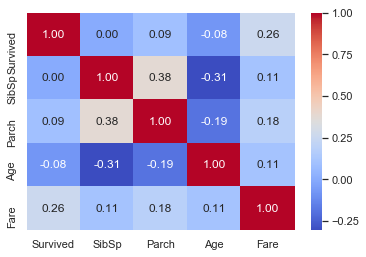

In [224]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not useful. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detain these features

### SibSp

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


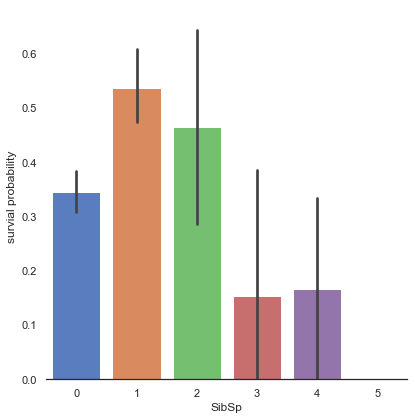

In [225]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6,
                  palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survial probability")

It seems that passengers having a lot of siblings/spouses have less chance to survived

Single passengers (0 SibSp) or with two other persons (SibSp 1 ot 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)

### Parch

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


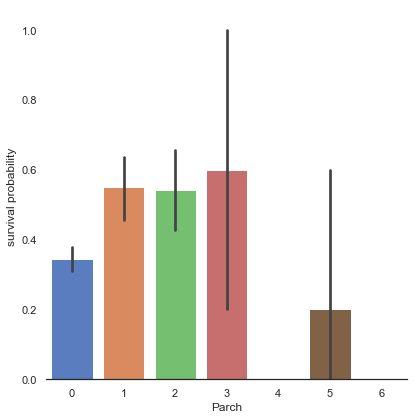

In [226]:
# Explore Parch feature vs Survived
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6,
                  palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single(Parch 0), medium (Parch 3,4) and large families (Parch 5,6).

Be careful there is an important standard deviation in the survial of passengers with 3parents/children

### Age

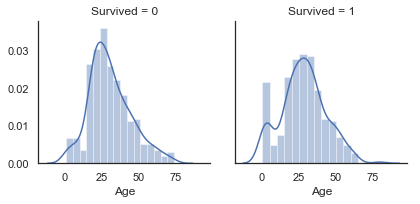

In [227]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age distribution seems to be tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, enven if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.

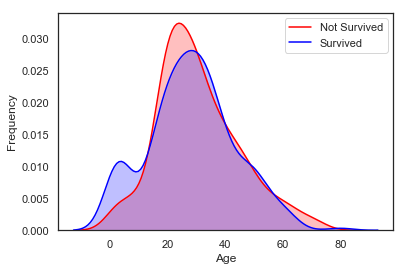

In [228]:
# Explore Age distribution
g = sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

When we superimpose the two densities, we clearly see a peak corresponding (between 0 and 5) to babies and very young childrens.

### Fare

In [229]:
dataset["Fare"].isnull().sum()

1

In [230]:
# Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Since we have one missing value, I decided to fill it with the median value which will not have an important effect on the prediction.

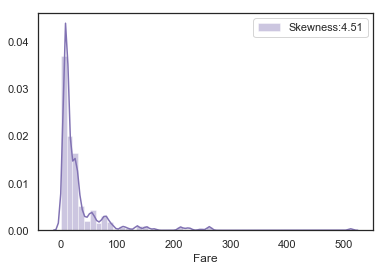

In [231]:
# Explore Fare distribution
g = sns.distplot(dataset["Fare"], color="m", label="Skewness:%.2f" %(dataset["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweight very high values in the model, even if is scaled.

In this case, It is better to transfrom it with the log function to reduce this skew.

In [232]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

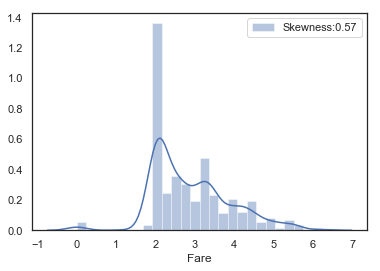

In [233]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness:%.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation

### 3.2 Categorical values

### Sex

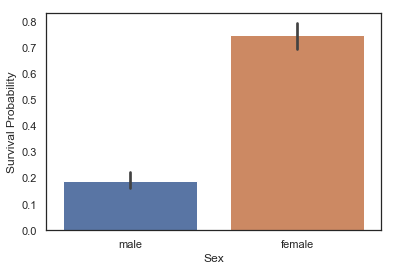

In [234]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [235]:
train[["Sex","Survived"]].groupby('Sex').mean()


,Survived
Sex,
female,0.747573
male,0.190559


It is clealy obvious that Male have less chance to survive than Female.

So sex, might play an important role in the prediction of the survial.

For those who have seen the Titanic movie(1997), I am sure, we all remember this sentence during the evacuation : __"Women and children first".__

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


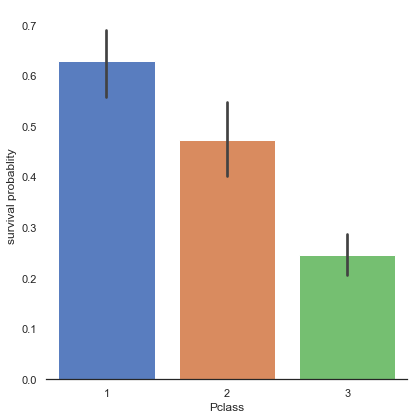

In [236]:
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6,
                  palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probablity")

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


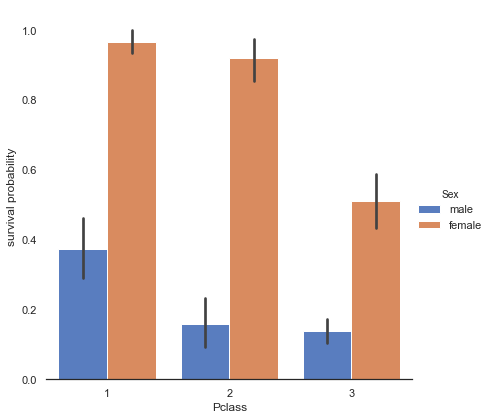

In [237]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

This trend is conserved when we loot at both male and female passengers.

### Embarked

In [238]:
dataset["Embarked"].isnull().sum()

2

In [239]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

Since we have two missing values, I decided to fill them with the most frequent value of "Embarked" (S).

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


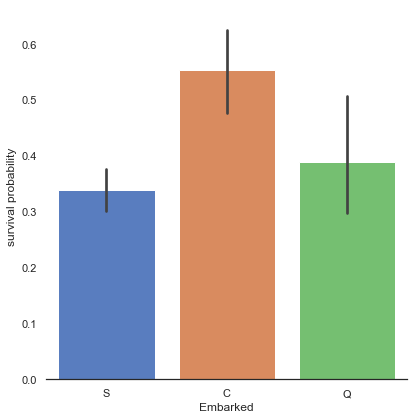

In [240]:
# Explore Embarked vs Survived
g = sns.factorplot(x="Embarked", y="Survived", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


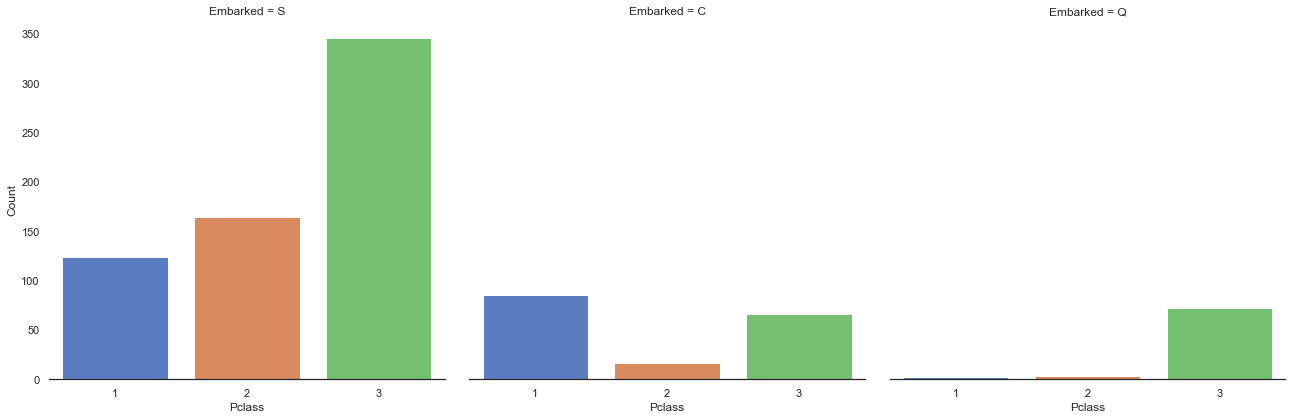

In [241]:
# Explore Pclass vs Embarked
g = sns.factorplot("Pclass", col="Embarked" ,data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passenger are mostly in first class which have the highest survival rate.

At this point, I can't explain why first class has an higher survial rate. My hypothesis is that first classs passengers were prioritised during the evacuation due to their influence.

# Filling missing Values

## 4.1 Age
As we see, Age column contains 256 misshing values in the whole dataset.

Since there is subpopulations that have more chance to survive (children for examplt), it is preferable to keep the age feature and to impute the missing values.

To address this problem, I looked at the most correlated features with Age(Age, Parch, Pclass and SibSp).

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) h

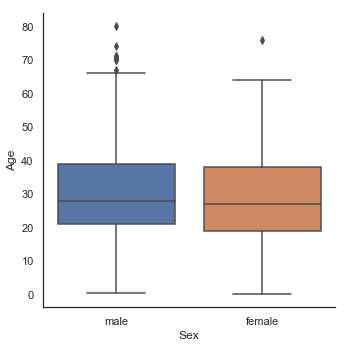

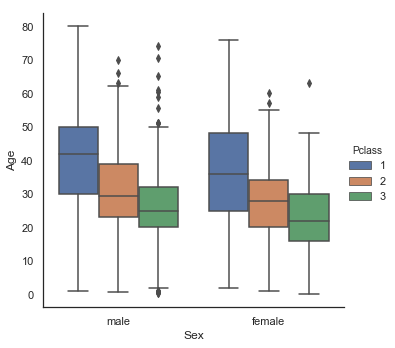

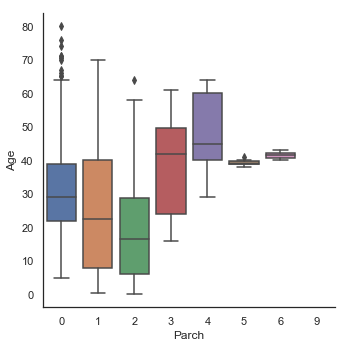

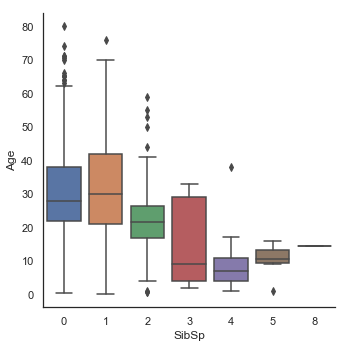

In [242]:
# Explore Age vs Sex, Parch, Pclass and SibSp
g = sns.factorplot(y="Age", x="Sex", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Sex", hue="Pclass", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="Parch", data=dataset, kind="box")
g = sns.factorplot(y="Age", x="SibSp", data=dataset, kind="box")

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.

So, I decided o use SibSp, Parch and Pclass in order to impute the missing ages.

The strategy is to fill Age wih the median age of similar rows according to Pclass, Parch and SibSp.

In [243]:
# Filling missing value of Age

## Fill Age with the median ange of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


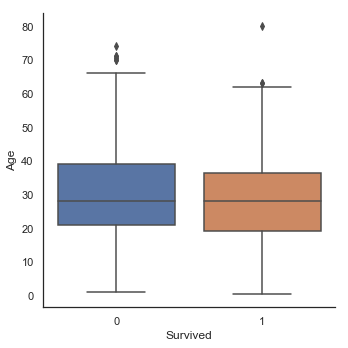

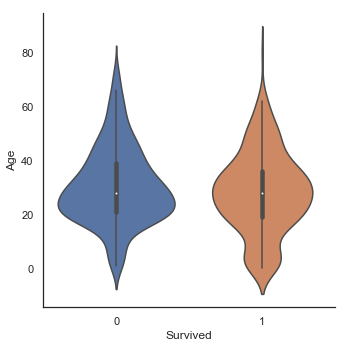

In [244]:
g = sns.factorplot(x="Survived", y="Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y="Age", data = train, kind = "violin")

 No differences between median value of age in survived and not survived subpopulation.
 
 But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.

# 5.Feature engineering

## 5.1 Name / Title

In [245]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The name feature contains information on passenger's title.

Since some passenger with distinguished title may be preferred during the evacuation, it is interesting to add them to the model.

In [246]:
# Get title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

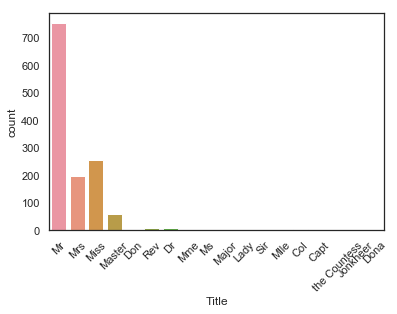

In [247]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [248]:
# Convert to cactegorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":0, "Ms":1, "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

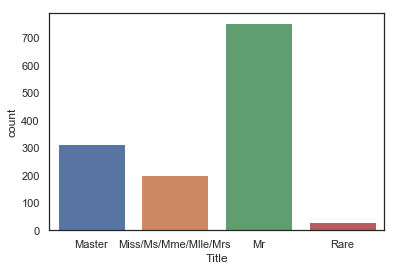

In [249]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


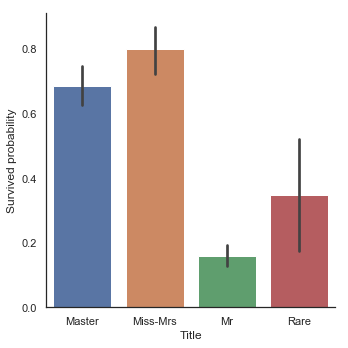

In [250]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("Survived probability")

"Women and children first"
It is interesting to note that passengers with rare title have more chance to survive.

In [251]:
# Drop name variable
dataset.drop(labels = ["Name"], axis=1, inplace=True)

## 5.2 Family Size

We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/ brothers/ parents during the evacuation. So, I choosed to create a "Fize"(Family Size)
feature which is the sum of SibSp, Parch and 1 (including the passenger).

In [252]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


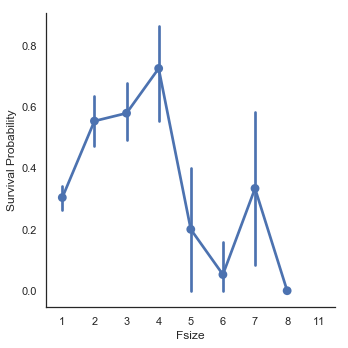

In [253]:
g = sns.factorplot(x="Fsize", y="Survived", data = dataset)
g = g.set_ylabels("Survival Probability")

The family size seems to play an important role, survival probablity is worst for large familes.
Additionally, I decided to created 4 categories of family size.

In [254]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s:1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s >= 5 else 0)

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) h

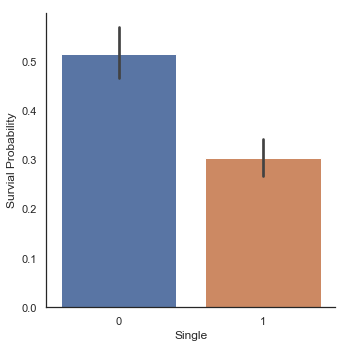

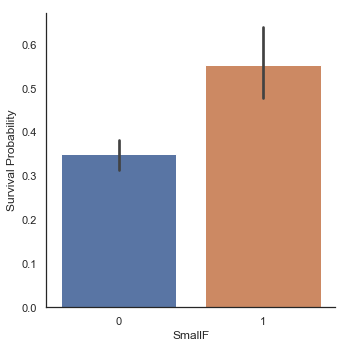

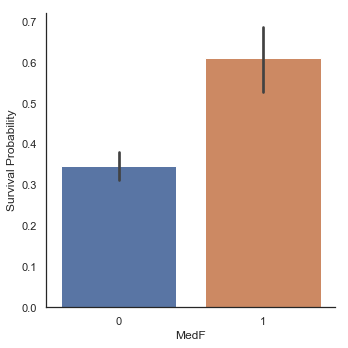

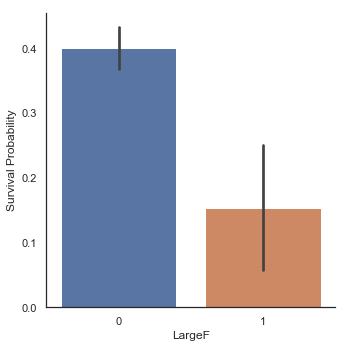

In [255]:
g = sns.factorplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survial Probability")
g = sns.factorplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large familes.

In [256]:
# Convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix = "Em")

In [257]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,male,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,female,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,0,0,0,1,0,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,female,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,male,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


At this stage, we have 22 features.

## 5.3 Cabin

In [258]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [259]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [260]:
dataset["Cabin"].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.

I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [261]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [262]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

The first letter of the cabin indicates the Desk, I choosed to keep this information only, since it indeicates the probable location of the passenger in the Titanic.

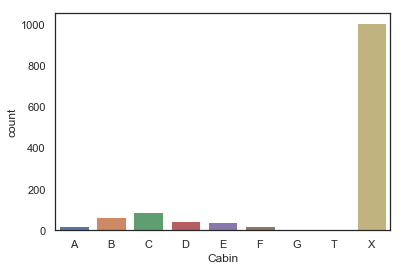

In [263]:
g = sns.countplot(dataset["Cabin"], order=['A','B','C','D','E','F','G','T','X'])

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


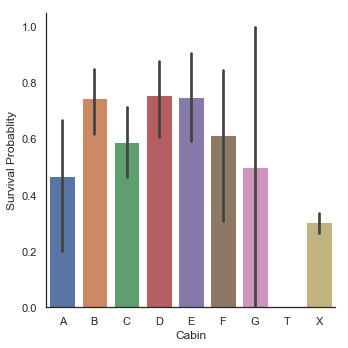

In [264]:
g = sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probablity")

Because of the low number of passenger that have a cabin, survial probablities have an important standatd deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B,C,D,E and F.

In [265]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

## 5.4 Ticket

In [266]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

Tickets with same prefixes may have a similar class and survival.

So I decided to replace the Ticket feature column by the ticket prefix. Which may be more informative.

In [267]:
## Treat Tickets by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [268]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [269]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix="Pc")

In [270]:
# Drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [271]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,male,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,female,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,female,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,female,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,male,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6.Modeling

In [272]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis = 1, inplace=True)

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [273]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/Users/heojeong-wook/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 6.1 Simple modeling

### 6.1.1 Cross validate models
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure

- SVC
- Decision Tree
- AdaBoos
- Random Forest
- Extra Trees
- Gradient Boosting
- Mutlple layer perceptron (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [274]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [275]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

ValueError: could not convert string to float: 'male'

I decided to choose the SVC, AdaBoost, RandomForest, ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

### 6.1.2 Hyperparameter tunning for best models
I performed a grid search optimization for AdaBoost, ExtraTrees, RandomForest, GradientBoosting and SVC classifiers.

I set the "n_jobs" parameter to 4 since I have 4 cpu. The computation time is clearly reduced.

But be carefull, this step can take a long time, I took me 15 min in total on 4 cpu.

In [278]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: could not convert string to float: 'male'

In [279]:
gsadaDTC.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'